In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import json
import pprint
import tensorflow as tf
from tensorflow_addons.metrics import F1Score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, TFBertModel, DistilBertTokenizer, TFDistilBertModel

loadDir = r'C:\Users\mz1391\Downloads\Masters_Berkeley_MIDS\W266_NLP_Deep_Learning\Final_Project\GWStance-master/'
loadFName = 'GWSD.tsv'
bertModelStr = 'bert-base-uncased'

rawData = pd.read_csv(loadDir + loadFName, sep='\t')
labeledInds = np.where(rawData['disagree'].notnull() == True)[0] # use only labeled examples
allSents = rawData.iloc[labeledInds]['sentence']
allLabels = rawData.iloc[labeledInds][['disagree', 'agree', 'neutral']].idxmax(axis=1) # determine "ground truth" label (based on outputs from a bayesian model developed by Luo et al., 2020)

# Load Engineered Features

In [2]:
# code used to get and save engineered features located in separate notebook (W266_finalProject_EDA_climatChangeText.ipynb)

loadDir = r'C:\Users\mz1391\Downloads\Masters_Berkeley_MIDS\W266_NLP_Deep_Learning\Final_Project\saved_files/'
fileName = 'engineeredFeatures.csv'

featuresDf = pd.read_csv(loadDir+fileName)
featuresDf = featuresDf.set_index(featuresDf['id']) # set to same indices as those used for train/dev split
featuresDf = featuresDf.drop(['id'], axis=1)
featuresDf = featuresDf.join(allSents) # join on text data
featuresDf.head()

,label,numTokens,bertSent,swnet_zscored,sentence
id,,,,,
5,agree,37,0.984627,0.143836,Warmer-than-normal sea surface temperatures ar...
6,neutral,20,-0.888233,0.797092,We will continue to rely in part on fossil fue...
7,neutral,28,-0.990997,-0.021293,The actual rise in sea levels measured only 1....
8,disagree,9,-0.955837,2.054611,Claims of global warming have been greatly exa...
9,neutral,35,-0.966280,0.390526,The Intergovernmental Panel on Climate Change ...


In [3]:
# split data into train, dev, and test sets (test examples are pre-deterimned by authors' labels) 
# - uses same seed as in EDA

devSize = 0.2

trainIds = rawData.loc[labeledInds].loc[rawData['in_held_out_test']==False].index.values
x_train, x_dev, y_trainStrs, y_devStrs = train_test_split(featuresDf.loc[trainIds], allLabels.loc[trainIds].tolist()
                                                  , test_size=devSize, random_state=1214)

testIds = rawData.loc[labeledInds].loc[rawData['in_held_out_test']==True].index.values
x_test = featuresDf.loc[testIds]
y_testStrs = allLabels.loc[testIds].tolist()

# Modeling

In [4]:
# prepare inputs

maxTokenLength = 90
nonBertFeaturesToUse = ['numTokens', 'bertSent', 'swnet_zscored']

# inputs for BERT (encodings)
tokenizer = BertTokenizer.from_pretrained(bertModelStr)
train_encodings = tokenizer(x_train['sentence'].tolist(), return_tensors='tf', padding='max_length', truncation=True, max_length=maxTokenLength)
dev_encodings = tokenizer(x_dev['sentence'].tolist(), return_tensors='tf', padding='max_length', truncation=True, max_length=maxTokenLength)
test_encodings = tokenizer(x_test['sentence'].tolist(), return_tensors='tf', padding='max_length', truncation=True, max_length=maxTokenLength)

# non-bert features
train_nonBertFeatures = tf.convert_to_tensor(np.array(x_train[nonBertFeaturesToUse]).astype(np.float32).reshape((len(x_train), len(nonBertFeaturesToUse))))
dev_nonBertFeatures = tf.convert_to_tensor(np.array(x_dev[nonBertFeaturesToUse]).astype(np.float32).reshape((len(x_dev), len(nonBertFeaturesToUse))))
test_nonBertFeatures = tf.convert_to_tensor(np.array(x_test[nonBertFeaturesToUse]).astype(np.float32).reshape((len(x_test), len(nonBertFeaturesToUse))))

# convert class labels from strings to one-hot encodings
# 'agree' = 0, 'disagree' = 1, 'neutral' = 2 (for random_state=1214 in train_test_split)
labelEncoder = LabelEncoder() 
labelEncoder.fit(y_trainStrs)
y_train = tf.keras.utils.to_categorical(labelEncoder.transform(y_trainStrs), num_classes=3, dtype='float32')
y_dev = tf.keras.utils.to_categorical(labelEncoder.transform(y_devStrs), num_classes=3, dtype='float32')
y_test = tf.keras.utils.to_categorical(labelEncoder.transform(y_testStrs), num_classes=3, dtype='float32')

# calculate class weights
numClasses = 3
totNumExamples = len(allLabels)
classWeights = dict.fromkeys([0,1,2])
for classNum in np.arange(numClasses):
    numExamplesInClass = len(allLabels.loc[allLabels==labelEncoder.inverse_transform([classNum])[0]])
    classWeights[classNum] = (1 / numExamplesInClass)*(totNumExamples)/numClasses

In [5]:
# build the model architecture

def train_fullModel(maxTokenLength, numNeuronsDense, learningRate, dropoutRate, onlyBertEmbed=True, numNonBertFeatures=0):
# inputs
    input_id = tf.keras.layers.Input(shape=(maxTokenLength,), dtype='int32', name='input_ids')
    input_mask = tf.keras.layers.Input(shape=(maxTokenLength,), dtype='int32', name='input_masks')
    input_segment = tf.keras.layers.Input(shape=(maxTokenLength,), dtype='int32', name='input_segment_ids')
    
    if onlyBertEmbed:
        modelInputs = [input_id, input_mask, input_segment]
    else: # if using other features, add them to the list of inputs
        input_nonBertFeatures = tf.keras.layers.Input(shape=(numNonBertFeatures,), dtype='float32', name='nonBertFeatures')
        modelInputs = [input_id, input_mask, input_segment, input_nonBertFeatures]

# bert pre-trained
    bertInputs = [input_id, input_mask, input_segment]
    bertPretrained = TFBertModel.from_pretrained(bertModelStr, from_pt=True)
    bertClsEmbed = bertPretrained(bertInputs)[1]

# dense layers
    if onlyBertEmbed:
        inputDense = bertClsEmbed
    else: # if available, concatenate additional features to BERT word embedding
        inputDense = tf.concat((bertClsEmbed, input_nonBertFeatures), axis=1, name='catNonBertFeatures')
        
    dense1 = tf.keras.layers.Dense(numNeuronsDense[0], activation='relu', name='dense1')(inputDense)
    dropout = tf.keras.layers.Dropout(rate=dropoutRate, name='dropout1')(dense1)
    y_predicted = tf.keras.layers.Dense(3, activation='softmax', name='outputLayer')(dropout)

# compile
    model = tf.keras.models.Model(inputs=modelInputs, outputs=y_predicted)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learningRate)
                  , loss='categorical_crossentropy'
                  , metrics=['accuracy', tf.keras.metrics.AUC(curve='ROC'), F1Score(num_classes=3, average='macro')]
                 )

    model.summary()
    
    return model

In [7]:
# fit the model on training data and evaluate on dev set

numNeuronsDense = [256]
learningRate = 2e-5
dropoutRate = 0.1
batchSize = 16
numEpochs = 5

modelInputs_train = [train_encodings['input_ids']
                    , train_encodings['attention_mask']
                    , train_encodings['token_type_ids']
                   ]
modelInputs_dev = [dev_encodings['input_ids']
                  , dev_encodings['attention_mask']
                  , dev_encodings['token_type_ids']
                 ]

with tf.device('/GPU:0'):
    tf.keras.backend.clear_session()
    
    model = train_fullModel(maxTokenLength, numNeuronsDense, learningRate, dropoutRate
                            , onlyBertEmbed=True
                            , numNonBertFeatures=len(nonBertFeaturesToUse)
                           )
        
    history = model.fit(modelInputs_train
                , y_train
                , validation_data=(modelInputs_dev, y_dev)
                , epochs=numEpochs
                , batch_size=batchSize
                , class_weight=classWeights
               )

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 90)]         0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 90)]         0                                            
__________________________________________________________________________________________________
input_segment_ids (InputLayer)  [(None, 90)]         0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_ids[0][0]                  
                                                                 input_masks[0][0]            

Text(0.5, 1.0, 'Baseline Model Training')

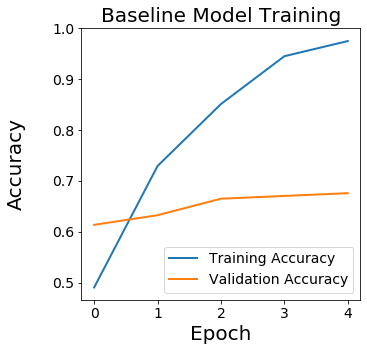

In [25]:
# plot train/dev accuracies by epoch

figH = plt.figure(figsize=(5,5))

plt.plot(history.history['accuracy'], linewidth=2)
plt.plot(history.history['val_accuracy'], linewidth=2)
plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=14)
plt.ylabel('Accuracy\n', fontsize=20)
plt.xlabel('Epoch', fontsize=20)
plt.xticks([0,1,2,3,4], fontsize=14)
plt.yticks([.5,.6,.7,.8,.9,1], fontsize=14)
plt.title('Baseline Model Training', fontsize=20)

# k-fold CV

In [6]:
# prepare inputs for kfold
from sklearn.model_selection import StratifiedKFold

numFolds = 5
maxTokenLength = 90
nonBertFeaturesToUse = ['numTokens']

tokenizer = BertTokenizer.from_pretrained(bertModelStr)
allEncodings_kfold = tokenizer(featuresDf.loc[trainIds]['sentence'].tolist(), return_tensors='tf', padding='max_length', truncation=True, max_length=maxTokenLength)
nonBertFeatures_kfold = tf.convert_to_tensor(np.array(featuresDf.loc[trainIds][nonBertFeaturesToUse]).astype(np.float32).reshape((len(trainIds), len(nonBertFeaturesToUse))))
y_kfold = tf.keras.utils.to_categorical(labelEncoder.fit_transform(allLabels.loc[trainIds].tolist()), num_classes=3, dtype='float32')


# get indices for doing k-fold CV
kfoldObj = StratifiedKFold(n_splits=numFolds)
kfoldInds = list(kfoldObj.split(featuresDf.loc[trainIds], y=allLabels.loc[trainIds].tolist()))


In [ ]:
numNeuronsDense = [256]
learningRate = 2e-5
dropoutRate = 0.1
batchSize = 16
numEpochs = 5

for foldInd in np.arange(numFolds):
    modelInputs_train = [tf.gather(allEncodings_kfold['input_ids'], kfoldInds[foldInd][0])
                         , tf.gather(allEncodings_kfold['attention_mask'], kfoldInds[foldInd][0])
                         , tf.gather(allEncodings_kfold['token_type_ids'], kfoldInds[foldInd][0])
                         , tf.gather(nonBertFeatures_kfold, kfoldInds[foldInd][0])
                        ]

    modelInputs_dev = [tf.gather(allEncodings_kfold['input_ids'], kfoldInds[foldInd][1])
                       , tf.gather(allEncodings_kfold['attention_mask'], kfoldInds[foldInd][1])
                       , tf.gather(allEncodings_kfold['token_type_ids'], kfoldInds[foldInd][1])
                       , tf.gather(nonBertFeatures_kfold, kfoldInds[foldInd][1])
                      ]

    with tf.device('/GPU:0'):
        tf.keras.backend.clear_session()

        model = train_fullModel(maxTokenLength, numNeuronsDense, learningRate, dropoutRate
                                , onlyBertEmbed=False
                                , numNonBertFeatures=len(nonBertFeaturesToUse)
                               )

        model.fit(modelInputs_train
                  , y_kfold[kfoldInds[foldInd][0]]
                  , validation_data=(modelInputs_dev, y_kfold[kfoldInds[foldInd][1]])
                  , epochs=numEpochs
                  , batch_size=batchSize
                  , class_weight=classWeights
                 )

        if foldInd == 0:
        # initiate dataframe to store results
            devMetrics = pd.DataFrame(columns=model.metrics_names)

        # Store performance metrics after evaluating on dev set
        devMetrics.loc[foldInd] = model.evaluate(modelInputs_dev, y_kfold[kfoldInds[foldInd][1]])
    

In [14]:
# check results of each fold
devMetrics

,loss,accuracy,auc,f1_score
0,1.344590,0.697297,0.830849,0.691515
1,1.257644,0.627027,0.812768,0.607531
2,1.285950,0.648649,0.819118,0.644039
3,1.237828,0.659459,0.808563,0.644120
4,1.054074,0.683784,0.853377,0.666450


In [15]:
# save results of CV

saveDir = r'C:\Users\mz1391\Downloads\Masters_Berkeley_MIDS\W266_NLP_Deep_Learning\Final_Project\saved_files/'
fileName = 'CV_bert_classWeights_ONLYnumTokens.csv'

devMetrics.to_csv(saveDir+fileName, index=False)

# load to see that save worked properly
pd.read_csv(saveDir+fileName)

,loss,accuracy,auc,f1_score
0,1.344590,0.697297,0.830849,0.691515
1,1.257644,0.627027,0.812768,0.607531
2,1.285950,0.648649,0.819118,0.644039
3,1.237828,0.659459,0.808563,0.644120
4,1.054074,0.683784,0.853377,0.666450


# Output results of different models 

In [7]:
saveDir = r'C:\Users\mz1391\Downloads\Masters_Berkeley_MIDS\W266_NLP_Deep_Learning\Final_Project\saved_files/'
fileName = 'CV_bert_NOclassWeights_NOengFeatures.csv'

# load to see that save worked properly
pd.read_csv(saveDir+fileName).mean()

loss        1.180357
accuracy    0.671892
auc         0.833501
f1_score    0.652107
dtype: float64

In [11]:
fileName = 'CV_bert_classWeights_NOengFeatures.csv'

# load to see that save worked properly
pd.read_csv(saveDir+fileName).mean()

loss        1.212268
accuracy    0.667027
auc         0.825702
f1_score    0.643627
dtype: float64

In [16]:
saveDir = r'C:\Users\mz1391\Downloads\Masters_Berkeley_MIDS\W266_NLP_Deep_Learning\Final_Project\saved_files/'
fileName = 'CV_bert_classWeights_ONLYnumTokens.csv'

# load to see that save worked properly
pd.read_csv(saveDir+fileName).mean()

loss        1.236017
accuracy    0.663243
auc         0.824935
f1_score    0.650731
dtype: float64

In [17]:
saveDir = r'C:\Users\mz1391\Downloads\Masters_Berkeley_MIDS\W266_NLP_Deep_Learning\Final_Project\saved_files/'
fileName = 'CV_bert_classWeights_ONLYswnet.csv'

# load to see that save worked properly
pd.read_csv(saveDir+fileName).mean()

loss        1.167497
accuracy    0.661081
auc         0.832196
f1_score    0.646802
dtype: float64

In [20]:
saveDir = r'C:\Users\mz1391\Downloads\Masters_Berkeley_MIDS\W266_NLP_Deep_Learning\Final_Project\saved_files/'
fileName = 'CV_bert_classWeights_ONLYbertSent.csv'

# load to see that save worked properly
pd.read_csv(saveDir+fileName).mean()

loss        1.163830
accuracy    0.685946
auc         0.841779
f1_score    0.661259
dtype: float64

In [4]:
fileName = 'CV_bert_3engFeatures.csv'

# load to see that save worked properly
pd.read_csv(saveDir+fileName).mean()

loss        1.244087
accuracy    0.669189
auc         0.828802
f1_score    0.654088
dtype: float64

In [90]:
# save model weights from best model of CV

saveDir = r'C:\Users\mz1391\Downloads\Masters_Berkeley_MIDS\W266_NLP_Deep_Learning\Final_Project\saved_files/saved_models/'
fileName = 'bert_3engFeatures'

# Create a callback that saves the model's weights
model.save_weights(saveDir+fileName)

In [12]:
# run saved model on held-out test data

loadDir = r'C:\Users\mz1391\Downloads\Masters_Berkeley_MIDS\W266_NLP_Deep_Learning\Final_Project\saved_files/saved_models/'
fileName = 'bert_3engFeatures'

maxTokenLength = 90
numNeuronsDense = [256]
learningRate = 2e-5
dropoutRate = 0.1
batchSize = 16
numEpochs = 5

with tf.device('/GPU:0'):
    model = train_fullModel(maxTokenLength, numNeuronsDense, learningRate, dropoutRate, onlyBertEmbed=False, numNonBertFeatures=3)

    model.load_weights(loadDir+fileName)

    modelInputs_test = [test_encodings['input_ids']
                        , test_encodings['attention_mask']
                        , test_encodings['token_type_ids']
                        , test_nonBertFeatures
                       ]

    model.evaluate(modelInputs_test, y_test)
    
    # get model predictions for confusion matrix in next cell
    y_pred = np.argmax(model.predict(modelInputs_test), axis=1)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 90)]         0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 90)]         0                                            
__________________________________________________________________________________________________
input_segment_ids (InputLayer)  [(None, 90)]         0                                            
__________________________________________________________________________________________________
tf_bert_model_2 (TFBertModel)   TFBaseModelOutputWit 109482240   input_ids[0][0]                  
                                                                 input_masks[0][0]          

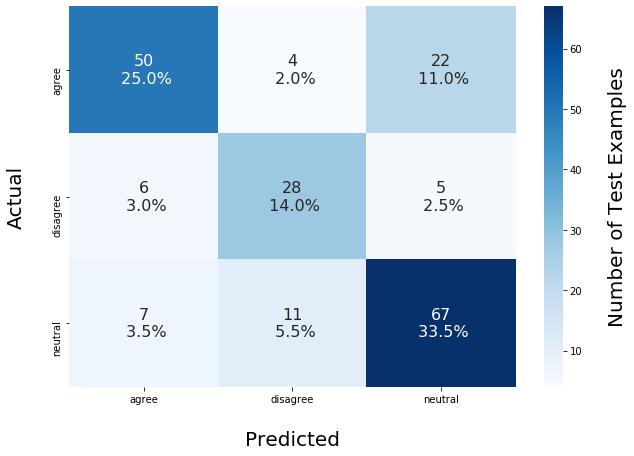

In [13]:
# confusion matrix of best model results

import seaborn as sns
from sklearn.metrics import confusion_matrix
    
# calculate confusion matrix
confusionMat = confusion_matrix(np.argmax(y_test, axis=1), y_pred)

# create labels and plot the confusion matrix
percents = [str(round(quadrant/sum(confusionMat.flatten())*100, 2))+'%' for quadrant in confusionMat.flatten()]
labels = (np.asarray(["{0:.3g}\n {1}".format(value, percent)
                      for value, percent in zip(confusionMat.flatten()
                                                , percents
                                               )
                     ])
         ).reshape(3, 3)

figH, axH = plt.subplots(figsize=(10, 7))
axH = sns.heatmap(confusionMat, annot=labels, annot_kws={"fontsize":16}, fmt=""
                  , cmap='Blues', cbar_kws={'label': '\nNumber of Test Examples'}
                 )
axH.figure.axes[-1].yaxis.label.set_size(20)
plt.xlabel('\nPredicted', fontsize=20)
plt.ylabel('Actual\n', fontsize=20)
axH.set_xticklabels(['agree', 'disagree', 'neutral'])
axH.set_yticklabels(['agree', 'disagree', 'neutral'])
plt.rcParams.update({'xtick.labelsize': 16,
                    'ytick.labelsize': 16})

In [80]:
# print examples of most common misclassifications (predict neutral but actual agree)

missedInds = np.intersect1d(np.argwhere(np.argmax(y_test, axis=1)==0), np.argwhere(y_pred==2))

testDf = featuresDf.loc[testIds]
pprint.pprint(list(enumerate(testDf.iloc[missedInds]['sentence'].tolist())))

[(0,
  'Progress in avoiding environmental regrets can come through constructive '
  'discussion of ways to cut risks and waste and to sustain a long-term energy '
  'quest that extends beyond fossil fuels even while they remain abundant and '
  'cheap.'),
 (1,
  'The globally averaged sea surface temperature for 2013 is among the 10 '
  'warmest on record.'),
 (2,
  'Global temperatures in 2014 shattered earlier records, making 2014 the '
  'hottest year since record-keeping began in 1880.'),
 (3,
  'By the year 2100, floods like the ones caused by Sandy could become '
  '1-in-20-year events.'),
 (4, 'A majority of respondents believe global warming has already begun.'),
 (5,
  'On the warmest day this month, half the ice sheet’s surface is melting, '
  'double the norm for this time of year.'),
 (6, 'We can expect the Arctic to be ice-free in summer within 20 years.'),
 (7,
  'The hidden health and environmental costs of using fossil fuels are far '
  'greater than previously thought